In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import env
from wrangle import *
from explore import *

# modeling methods
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, StandardScaler, MinMaxScaler
from scipy import stats
from sklearn.feature_selection import SelectKBest, f_regression, RFE

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Acquire data

df = acquire_zillow()

In [3]:
df.head()

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,propertylandusedesc,transactiondate,latitude,longitude,lotsizesquarefeet,garagecarcnt
0,3.0,2.0,1125.0,289445.0,1974.0,3490.16,6059.0,Condominium,2017-08-04,33922098.0,-117954970.0,NaN,1.0
1,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,Single Family Residential,2017-07-21,34033180.0,-118355396.0,5672.0,NaN
2,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0,Single Family Residential,2017-06-23,34686163.0,-118113100.0,8284.0,NaN
3,3.0,2.0,1766.0,810694.0,1980.0,9407.01,6037.0,Condominium,2017-07-28,34073222.0,-118390965.0,25082.0,NaN
4,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0,Single Family Residential,2017-06-30,33999877.0,-118291863.0,6707.0,NaN


In [4]:
df.shape

(38582, 13)

In [5]:
# Remove Outliers

col_list = ['bedrooms','bathrooms','area','tax_value','taxamount']
df = remove_outliers(df,2,col_list)

In [6]:
df.shape

(35380, 13)

In [7]:
# Drop taxamount, tax_value is our target
df.drop(columns = 'taxamount', inplace = True)

In [8]:
# Imputing year_built with most_frequent value

imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(df[['year_built']])
df[['year_built']] = imputer.transform(df[['year_built']])

In [9]:
# Imputing lotsize with mean

imputer = SimpleImputer(strategy='mean')
imputer.fit(df[['lotsizesquarefeet']])
df[['lotsizesquarefeet']] = imputer.transform(df[['lotsizesquarefeet']])

In [10]:
# Fill garagecarcnt

df['garagecarcnt'] = df['garagecarcnt'].fillna(0)


In [11]:
# Checking for nulls

df.isnull().any()

bedrooms               False
bathrooms              False
area                   False
tax_value              False
year_built             False
fips                   False
propertylandusedesc    False
transactiondate        False
latitude               False
longitude              False
lotsizesquarefeet      False
garagecarcnt           False
dtype: bool

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35380 entries, 0 to 38581
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bedrooms             35380 non-null  float64
 1   bathrooms            35380 non-null  float64
 2   area                 35380 non-null  float64
 3   tax_value            35380 non-null  float64
 4   year_built           35380 non-null  float64
 5   fips                 35380 non-null  float64
 6   propertylandusedesc  35380 non-null  object 
 7   transactiondate      35380 non-null  object 
 8   latitude             35380 non-null  float64
 9   longitude            35380 non-null  float64
 10  lotsizesquarefeet    35380 non-null  float64
 11  garagecarcnt         35380 non-null  float64
dtypes: float64(10), object(2)
memory usage: 3.5+ MB


In [13]:
df.propertylandusedesc.value_counts()

Single Family Residential    25186
Condominium                   9977
Cluster Home                   185
Mobile Home                     27
Townhouse                        3
Residential General              2
Name: propertylandusedesc, dtype: int64

In [14]:
# Revisit this by encoding property

# Dropping low count propertylandusedec

df = df[df.propertylandusedesc != 'Residential General']
df = df[df.propertylandusedesc != 'Townhouse']


# Dropping propertylandusedesc

df.drop(columns = 'propertylandusedesc', inplace=True)



In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35375 entries, 0 to 38581
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedrooms           35375 non-null  float64
 1   bathrooms          35375 non-null  float64
 2   area               35375 non-null  float64
 3   tax_value          35375 non-null  float64
 4   year_built         35375 non-null  float64
 5   fips               35375 non-null  float64
 6   transactiondate    35375 non-null  object 
 7   latitude           35375 non-null  float64
 8   longitude          35375 non-null  float64
 9   lotsizesquarefeet  35375 non-null  float64
 10  garagecarcnt       35375 non-null  float64
dtypes: float64(10), object(1)
memory usage: 3.2+ MB


In [16]:
# Converting transactiondate into datetime

df['transactiondate'] = pd.to_datetime(df['transactiondate'],\
                        format = '%Y-%m-%d', errors = 'coerce')

# Creating columns for month, day, and week. We know they're all 2017
# so we don't need year

df['transactiondate_month'] = df['transactiondate'].dt.month
df['transactiondate_day'] = df['transactiondate'].dt.day
df['transactiondate_week'] = df['transactiondate'].dt.week

# Dropping transactiondate

df.drop(columns='transactiondate', inplace=True)

df.head()

,bedrooms,bathrooms,area,tax_value,year_built,fips,latitude,longitude,lotsizesquarefeet,garagecarcnt,transactiondate_month,transactiondate_day,transactiondate_week
0,3.0,2.0,1125.0,289445.0,1974.0,6059.0,33922098.0,-117954970.0,30057.802609,1.0,8,4,31
1,3.0,2.0,1316.0,205123.0,1923.0,6037.0,34033180.0,-118355396.0,5672.000000,0.0,7,21,29
2,3.0,2.0,1458.0,136104.0,1970.0,6037.0,34686163.0,-118113100.0,8284.000000,0.0,6,23,25
3,3.0,2.0,1766.0,810694.0,1980.0,6037.0,34073222.0,-118390965.0,25082.000000,0.0,7,28,30
4,2.0,1.0,1421.0,35606.0,1911.0,6037.0,33999877.0,-118291863.0,6707.000000,0.0,6,30,26


In [17]:
# Dropping my date columns because it ended up improving my performance when I did

df.drop(columns = ['transactiondate_month','transactiondate_day','transactiondate_week'], inplace = True)

In [18]:
# Last check to see column data types

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35375 entries, 0 to 38581
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedrooms           35375 non-null  float64
 1   bathrooms          35375 non-null  float64
 2   area               35375 non-null  float64
 3   tax_value          35375 non-null  float64
 4   year_built         35375 non-null  float64
 5   fips               35375 non-null  float64
 6   latitude           35375 non-null  float64
 7   longitude          35375 non-null  float64
 8   lotsizesquarefeet  35375 non-null  float64
 9   garagecarcnt       35375 non-null  float64
dtypes: float64(10)
memory usage: 3.0 MB


In [19]:
# train/validate/test split
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

In [20]:
train.shape

(19810, 10)

In [21]:
train.head()

,bedrooms,bathrooms,area,tax_value,year_built,fips,latitude,longitude,lotsizesquarefeet,garagecarcnt
22261,3.0,2.0,1549.0,553000.0,1955.0,6037.0,33946172.0,-117989019.0,8982.000000,0.0
23374,1.0,1.0,621.0,85939.0,1974.0,6059.0,33709700.0,-117906000.0,30057.802609,1.0
17512,4.0,2.0,1829.0,374531.0,1976.0,6037.0,34121963.0,-117777894.0,10813.000000,0.0
12316,3.0,2.0,1235.0,53615.0,1955.0,6059.0,33836207.0,-117898544.0,6138.000000,1.0
36039,4.0,3.0,2168.0,85918.0,1965.0,6059.0,33885191.0,-117846749.0,7000.000000,2.0


In [22]:
validate.shape

(8490, 10)

In [23]:
test.shape

(7075, 10)

In [24]:
def corr_heatmap(train): 
# Make a heatmap that shows correlation of churn and other variables
    plt.figure(figsize=(8, 12))
    heatmap = sns.heatmap(train.corr()[['tax_value']].sort_values(by='tax_value',ascending=False), vmin=-1, vmax=1, annot=True, cmap='Greens')
    heatmap.set_title('Correlation of Features with Tax Value', fontdict={'fontsize':18}, pad=16);

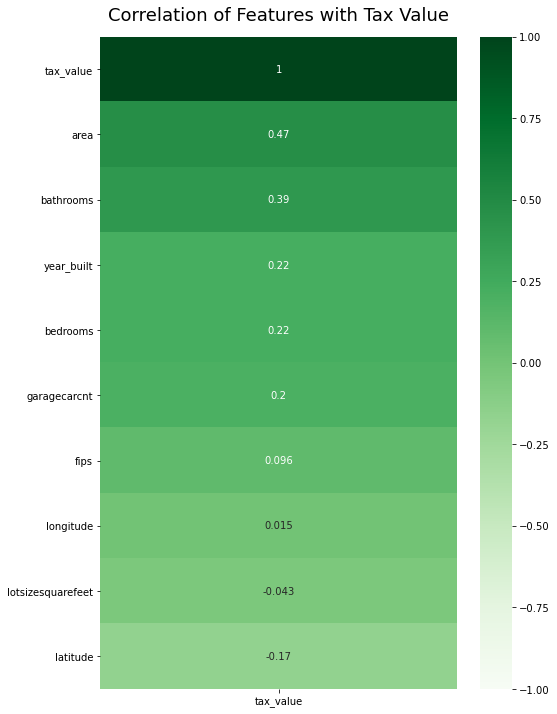

In [25]:
corr_heatmap(train)

#### 

In [26]:
train.fips.value_counts()

6037.0    12322
6059.0     5659
6111.0     1829
Name: fips, dtype: int64

In [27]:
# drop target column
X_train = train.drop(columns = 'tax_value')
y_train = train.tax_value

X_validate = validate.drop(columns = 'tax_value')
y_validate = validate.tax_value

X_test = test.drop(columns = 'tax_value')
y_test = test.tax_value

In [28]:
# scaling my X data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

In [29]:
X_validate = pd.DataFrame(X_validate)
type(X_validate)

pandas.core.frame.DataFrame

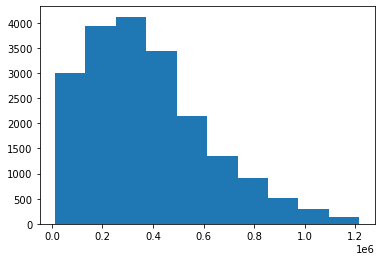

In [30]:
plt.hist(y_train)
plt.show()

## Modeling

### Baseline

About the initial baseline: 

> Before we begin making models, we need to know how well we can estimate (predict) the tax_value without using any features. We will try both the mean and the median, see which performs best, and set that evaluation metric value as our baseline performance to beat. 


In [31]:
# We need y_train, y_validate and y_test to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

# 1. compute tax_value_pred_mean
tax_value_pred_mean = y_train.tax_value.mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

# 2. compute tax_value_pred_median
tax_value_pred_median = y_train.tax_value.median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

# 3. RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean) ** .5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  237870.62 
Validate/Out-of-Sample:  240519.01


In [32]:
# 4. RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  240952.01 
Validate/Out-of-Sample:  243849.92


In [33]:
def make_metric_df(y, y_pred, model_name, metric_df):
    if metric_df.size ==0:
        metric_df = pd.DataFrame(data=[
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }])
        return metric_df
    else:
        return metric_df.append(
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }, ignore_index=True)

In [34]:
# create the metric_df as a blank dataframe
metric_df = pd.DataFrame()
# make our first entry into the metric_df with median baseline
metric_df = make_metric_df(y_train.tax_value,
                           y_train.tax_value_pred_mean,
                           'mean_baseline',
                          metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,237870.624744,0.0


### LinearRegression (OLS)

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict tax_value in training sample using our model (lm). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [35]:
# create the model object
# 
# make the thing
# 
lm = LinearRegression(normalize=True)

In [36]:
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# 
lm.fit(X_train, y_train.tax_value)

LinearRegression(normalize=True)

In [37]:
# predict train
# 
# use the thing!
# 
y_train['tax_value_pred_lm'] = lm.predict(X_train)

In [38]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm) ** .5

# predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  198452.32719418284 
Validation/Out-of-Sample:  200040.20440184048


In [39]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_lm)}, ignore_index=True)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,237870.624744,0.000000
1,OLS Regressor,200040.204402,0.308233


### LassoLars

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict tax_value in training sample using our model (lars). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [40]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars) ** (1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  198454.16244012164 
Validation/Out-of-Sample:  200040.20440184048


In [41]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.tax_value_pred_lars,
               'lasso_alpha_1',
               metric_df)

In [42]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,237870.624744,0.000000
1,OLS Regressor,200040.204402,0.308233
2,lasso_alpha_1,200062.340575,0.308080


### TweedieRegressor (GLM)

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict tax_value in training sample using our model (glm). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [43]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm) ** (1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  198792.70717917514 
Validation/Out-of-Sample:  198792.70717917514


In [44]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.tax_value_pred_glm,
               'glm_poisson',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,237870.624744,0.000000
1,OLS Regressor,200040.204402,0.308233
2,lasso_alpha_1,200062.340575,0.308080
3,glm_poisson,200053.389848,0.308142


### Polynomial Regression

Using sklearn.preprocessing.PolynommialFeatures() + sklearn.linear_model.LinearRegression()

1. Create the new features, based on value indicated for degree for train, validate & test. 

2. Fit the Linear Regression model

3. Predict using the transformed (squared or cubed, e.g.) features 

4. Evaluate using RMSE

5. Repeat predictions and evaluation for validation.

6. Compare RMSE train vs. validation. Overfitting?

## **PolynomialFeatures**

In [45]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_test)

## **LinearRegression**

In [46]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2) ** (1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2) 

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2) ** (1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  192391.2745865899 
Validation/Out-of-Sample:  193226.228663517


In [47]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.tax_value_pred_lm2,
               'quadratic',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,237870.624744,0.000000
1,OLS Regressor,200040.204402,0.308233
2,lasso_alpha_1,200062.340575,0.308080
3,glm_poisson,200053.389848,0.308142
4,quadratic,193226.228664,0.354559


### Evaluate

**Plotting Actual vs. Predicted Values**

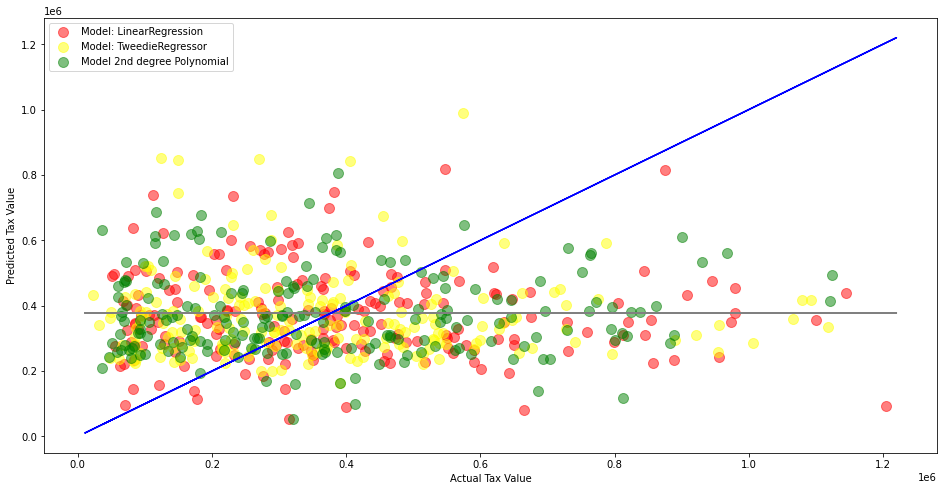

In [48]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.tax_value_pred_mean, alpha=1, color="gray", label='_nolegend_')
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=1, color="blue", label='_nolegend_')

plt.scatter(y_validate.tax_value.sample(n=200), y_validate.tax_value_pred_lm.sample(n=200), 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value.sample(n=200), y_validate.tax_value_pred_glm.sample(n=200), 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value.sample(n=200), y_validate.tax_value_pred_lm2.sample(n=200), 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")

plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.show()

#### Residual Plots: Plotting the Errors in Predictions

In [49]:
y_validate.tax_value.sample(n=100)

18111    142446.0
18415    624000.0
11054    422081.0
23891    220445.0
13921    244753.0
           ...   
30073    516000.0
28728    181754.0
20118    649648.0
6798     787251.0
29340     98282.0
Name: tax_value, Length: 100, dtype: float64

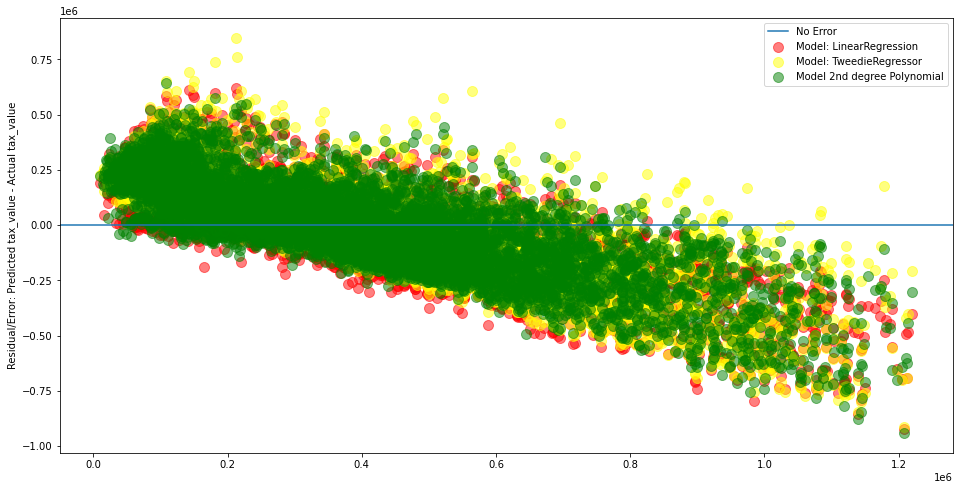

In [50]:
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm - y_validate.tax_value , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm - y_validate.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2 - y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.ylabel("Residual/Error: Predicted tax_value - Actual tax_value")
plt.show()

#### Histograms

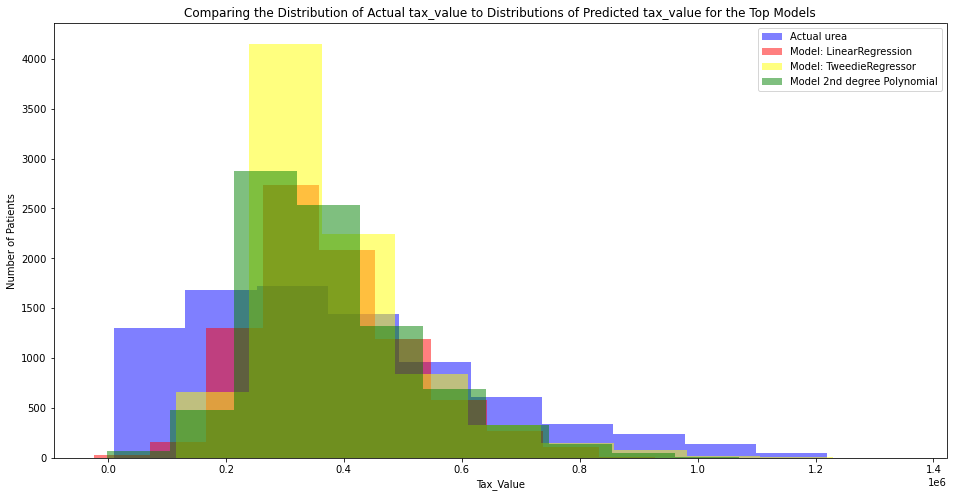

In [51]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual urea")
plt.hist(y_validate.tax_value_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.tax_value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.tax_value_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tax_Value")
plt.ylabel("Number of Patients")
plt.title("Comparing the Distribution of Actual tax_value to Distributions of Predicted tax_value for the Top Models")
plt.legend()
plt.show()

In [52]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,237870.624744,0.000000
1,OLS Regressor,200040.204402,0.308233
2,lasso_alpha_1,200062.340575,0.308080
3,glm_poisson,200053.389848,0.308142
4,quadratic,193226.228664,0.354559


In [53]:
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
#lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2) ** (1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2) 

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2) ** (1/2)

# predict test
y_test['tax_value_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm2) ** (1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train,
      "\nValidate/Out-of-Sample: ", rmse_validate,
      "\nTest/Out-of-Sample: ", rmse_test)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  192391.2745865899 
Validate/Out-of-Sample:  193226.228663517 
Test/Out-of-Sample:  191171.98914751547


In [54]:
metric_df = make_metric_df(y_test.tax_value,
               y_test.tax_value_pred_lm2,
               'test_quadratic',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,237870.624744,0.000000
1,OLS Regressor,200040.204402,0.308233
2,lasso_alpha_1,200062.340575,0.308080
3,glm_poisson,200053.389848,0.308142
4,quadratic,193226.228664,0.354559
5,test_quadratic,191171.989148,0.354442


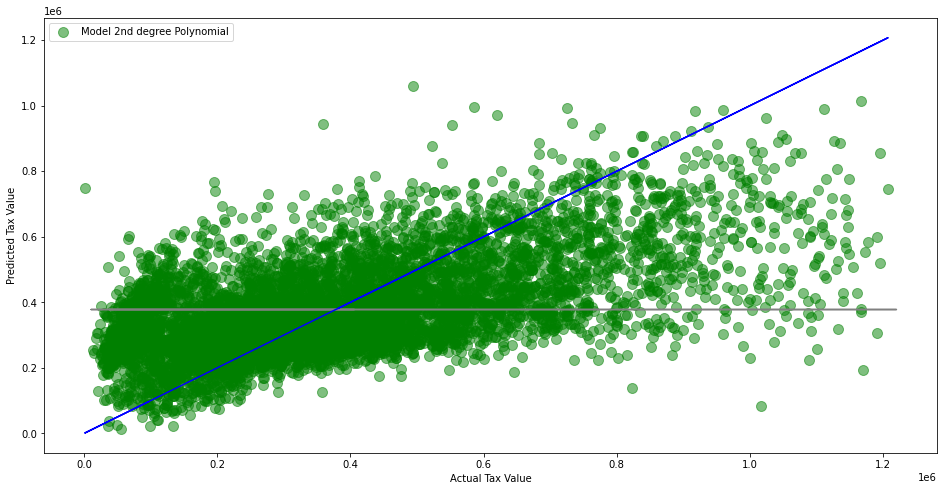

In [55]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.tax_value_pred_mean, alpha=1, color="gray", label='_nolegend_')
plt.plot(y_test.tax_value, y_test.tax_value, alpha=1, color="blue", label='_nolegend_')

plt.scatter(y_test.tax_value, y_test.tax_value_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")

plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.show()

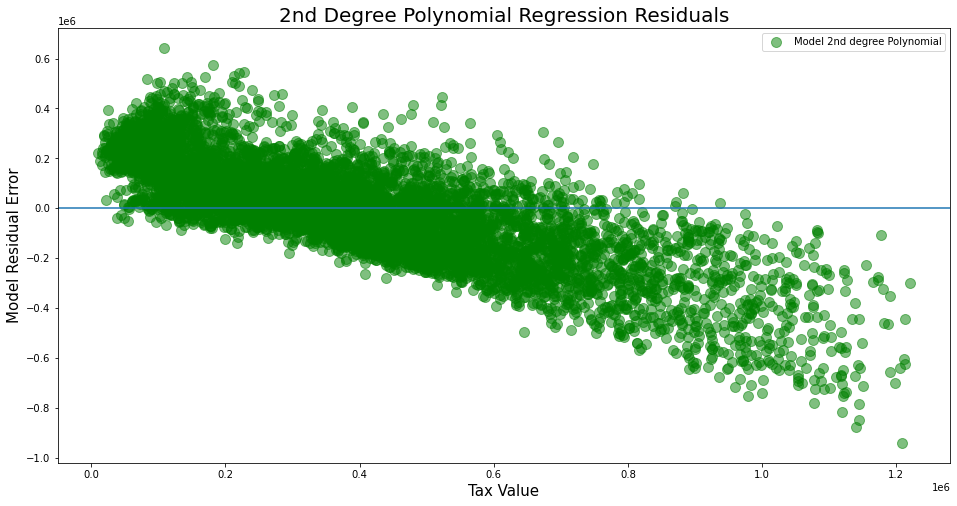

In [56]:
plt.figure(figsize=(16,8))
plt.axhline()
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2 - y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel('Tax Value', fontsize = 15)
plt.ylabel("Model Residual Error", fontsize =15)
plt.title("2nd Degree Polynomial Regression Residuals", fontsize=20)
plt.show()

In [57]:
def rfe(X,y,k):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=k)
    rfe.fit(X_train_scaled, y_train)
    X_train.columns[rfe.get_support()]
    return pd.Series(rfe.ranking_, index=X_train.columns).sort_values()


In [58]:
X = df.drop(columns='tax_value')
y = df.tax_value

In [59]:
rfe(X,y,1)

area                 1
latitude             2
bedrooms             3
longitude            4
year_built           5
fips                 6
bathrooms            7
garagecarcnt         8
lotsizesquarefeet    9
dtype: int64

In [60]:
train.columns

Index(['bedrooms', 'bathrooms', 'area', 'tax_value', 'year_built', 'fips',
       'latitude', 'longitude', 'lotsizesquarefeet', 'garagecarcnt'],
      dtype='object')

In [61]:
# Running the model with just bed bath and area

#train/validate/test split

train_validate, test = train_test_split(df, test_size=.2, random_state=321)
train, validate = train_test_split(train_validate, test_size=.3, random_state=321)


# drop target column and leaving more selective columns
X_train = train.drop(columns = ['tax_value','year_built','fips','latitude',\
                                'longitude','lotsizesquarefeet','garagecarcnt'])
y_train = train.tax_value

X_validate = validate.drop(columns = ['tax_value','year_built','fips','latitude',\
                                'longitude','lotsizesquarefeet','garagecarcnt'])
y_validate = validate.tax_value

X_test = test.drop(columns = ['tax_value','year_built','fips','latitude',\
                                'longitude','lotsizesquarefeet','garagecarcnt'])
y_test = test.tax_value


# scaling my X data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)


In [62]:
# We need y_train, y_validate and y_test to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

# 1. compute tax_value_pred_mean
tax_value_pred_mean = y_train.tax_value.mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

# 2. compute tax_value_pred_median
tax_value_pred_median = y_train.tax_value.median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

# 3. RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean) ** .5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  239086.76 
Validate/Out-of-Sample:  238719.01


In [63]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_test)

In [64]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2) ** (1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2) 

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2) ** (1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  207845.7641275226 
Validation/Out-of-Sample:  205014.9240092389


In [65]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.tax_value_pred_lm2,
               'only_bed_bath_area_quadratic',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,237870.624744,0.000000
1,OLS Regressor,200040.204402,0.308233
2,lasso_alpha_1,200062.340575,0.308080
3,glm_poisson,200053.389848,0.308142
4,quadratic,193226.228664,0.354559
5,test_quadratic,191171.989148,0.354442
6,only_bed_bath_area_quadratic,205014.924009,0.262263


#### Takeaways:
- Changing the "K" in the outliers produced a much better result, when K = 1.5, my mean_baseline RMSE - test_quadratic was 36,926 with a 30% explained variance
- Now with K = 2, the spread is 46,699 with 35% explained variance

### What if we don't remove outliers....(spolier alert, it's not great)

In [66]:
# Acquire data

df = acquire_zillow()

In [67]:
df.shape

(38582, 13)

In [68]:
# Drop taxamount, tax_value is our target
df.drop(columns = 'taxamount', inplace = True)

In [69]:
# Imputing year_built with most_frequent value

imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(df[['year_built']])
df[['year_built']] = imputer.transform(df[['year_built']])

In [70]:
# Imputing lotsize with mean

imputer = SimpleImputer(strategy='mean')
imputer.fit(df[['lotsizesquarefeet']])
df[['lotsizesquarefeet']] = imputer.transform(df[['lotsizesquarefeet']])

In [71]:
# Fill garagecarcnt

df['garagecarcnt'] = df['garagecarcnt'].fillna(0)


In [72]:
# Checking for nulls

df.isnull().any()

bedrooms               False
bathrooms              False
area                    True
tax_value               True
year_built             False
fips                   False
propertylandusedesc    False
transactiondate        False
latitude               False
longitude              False
lotsizesquarefeet      False
garagecarcnt           False
dtype: bool

In [73]:
df.area.isnull().value_counts()

False    38474
True       108
Name: area, dtype: int64

In [74]:
df.tax_value.isnull().value_counts()

False    38581
True         1
Name: tax_value, dtype: int64

In [75]:
df = df.dropna()
df.isnull().any()

bedrooms               False
bathrooms              False
area                   False
tax_value              False
year_built             False
fips                   False
propertylandusedesc    False
transactiondate        False
latitude               False
longitude              False
lotsizesquarefeet      False
garagecarcnt           False
dtype: bool

In [76]:
df.propertylandusedesc.value_counts()

Single Family Residential    28076
Condominium                  10171
Cluster Home                   186
Mobile Home                     28
Residential General              9
Townhouse                        3
Name: propertylandusedesc, dtype: int64

In [77]:
# Dropping low count propertylandusedec

df = df[df.propertylandusedesc != 'Residential General']
df = df[df.propertylandusedesc != 'Townhouse']

In [78]:
df.propertylandusedesc = df.propertylandusedesc.replace(to_replace = ['Single Family Residential','Condominium','Cluster Home','Mobile Home'],\
                              value = [0,1,2,3])

In [79]:
df.propertylandusedesc.value_counts()

0    28076
1    10171
2      186
3       28
Name: propertylandusedesc, dtype: int64

In [80]:
# Converting transactiondate into datetime

df['transactiondate'] = pd.to_datetime(df['transactiondate'],\
                        format = '%Y-%m-%d', errors = 'coerce')

# Creating columns for month, day, and week. We know they're all 2017
# so we don't need year

df['transactiondate_month'] = df['transactiondate'].dt.month
df['transactiondate_day'] = df['transactiondate'].dt.day
df['transactiondate_week'] = df['transactiondate'].dt.week

# Dropping transactiondate

df.drop(columns='transactiondate', inplace=True)

df.head()

,bedrooms,bathrooms,area,tax_value,year_built,fips,propertylandusedesc,latitude,longitude,lotsizesquarefeet,garagecarcnt,transactiondate_month,transactiondate_day,transactiondate_week
0,3.0,2.0,1125.0,289445.0,1974.0,6059.0,1,33922098.0,-117954970.0,29647.903297,1.0,8,4,31
1,3.0,2.0,1316.0,205123.0,1923.0,6037.0,0,34033180.0,-118355396.0,5672.000000,0.0,7,21,29
2,3.0,2.0,1458.0,136104.0,1970.0,6037.0,0,34686163.0,-118113100.0,8284.000000,0.0,6,23,25
3,3.0,2.0,1766.0,810694.0,1980.0,6037.0,1,34073222.0,-118390965.0,25082.000000,0.0,7,28,30
4,2.0,1.0,1421.0,35606.0,1911.0,6037.0,0,33999877.0,-118291863.0,6707.000000,0.0,6,30,26


In [81]:
# Dropping my date columns because it ended up improving my performance when I did

df.drop(columns = ['transactiondate_month','transactiondate_day','transactiondate_week'], inplace = True)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38461 entries, 0 to 38581
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bedrooms             38461 non-null  float64
 1   bathrooms            38461 non-null  float64
 2   area                 38461 non-null  float64
 3   tax_value            38461 non-null  float64
 4   year_built           38461 non-null  float64
 5   fips                 38461 non-null  float64
 6   propertylandusedesc  38461 non-null  int64  
 7   latitude             38461 non-null  float64
 8   longitude            38461 non-null  float64
 9   lotsizesquarefeet    38461 non-null  float64
 10  garagecarcnt         38461 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 3.5 MB


In [83]:
#train/validate/test split
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

In [84]:
train.columns

Index(['bedrooms', 'bathrooms', 'area', 'tax_value', 'year_built', 'fips',
       'propertylandusedesc', 'latitude', 'longitude', 'lotsizesquarefeet',
       'garagecarcnt'],
      dtype='object')

In [85]:
# drop target column
X_train = train.drop(columns = 'tax_value')
y_train = train.tax_value

X_validate = validate.drop(columns = 'tax_value')
y_validate = validate.tax_value

X_test = test.drop(columns = 'tax_value')
y_test = test.tax_value

In [86]:
# scaling my X data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

In [87]:
X_validate = pd.DataFrame(X_validate)
type(X_validate)

pandas.core.frame.DataFrame

In [88]:
# We need y_train, y_validate and y_test to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

# 1. compute tax_value_pred_mean
tax_value_pred_mean = y_train.tax_value.mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

# 2. compute tax_value_pred_median
tax_value_pred_median = y_train.tax_value.median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

# 3. RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean) ** .5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  619174.22 
Validate/Out-of-Sample:  642076.24


In [89]:
# 4. RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  633245.89 
Validate/Out-of-Sample:  655114.81


In [90]:
# create the metric_df as a blank dataframe
metric_df = pd.DataFrame()
# make our first entry into the metric_df with median baseline
metric_df = make_metric_df(y_train.tax_value,
                           y_train.tax_value_pred_mean,
                           'mean_baseline',
                          metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,619174.223133,0.0


In [91]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_test)

In [92]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2) ** (1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2) 

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2) ** (1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  433915.2723819605 
Validation/Out-of-Sample:  462648.4763297907


In [93]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.tax_value_pred_lm2,
               'quadratic',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,619174.223133,0.000000
1,quadratic,462648.476330,0.480799


In [94]:
619174 - 462648

156526

In [95]:
def rfe(X,y,k):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=k)
    rfe.fit(X_train_scaled, y_train)
    X_train.columns[rfe.get_support()]
    return pd.Series(rfe.ranking_, index=X_train.columns).sort_values()


In [96]:
X = df.drop(columns='tax_value')
y = df.tax_value

In [97]:
rfe(X,y,1)

area                    1
bedrooms                2
latitude                3
longitude               4
fips                    5
bathrooms               6
year_built              7
garagecarcnt            8
propertylandusedesc     9
lotsizesquarefeet      10
dtype: int64

#### Takeaways:
Extremely high RMSE and r2 value